# 🔬 Simulación Cuántica de H₂ - Replicación del Paper

**Paper**: arXiv:2405.05696v1 - *"Investigating entropic dynamics of complicated cavity QED system"*

Este notebook replica la dinámica entrópica del modelo de asociación-disociación de la molécula de hidrógeno neutral.

---

## 📋 Descripción del Sistema (7 subsistemas)

| Índice | Símbolo | Descripción | Tipo |
|--------|---------|-------------|------|
| 0 | p₁ | Fotón Ω↑ | Bosónico |
| 1 | p₂ | Fotón Ω↓ | Bosónico |
| 2 | m | Fonón ω | Bosónico |
| 3 | l₁ | Electrón ↑ | 2 niveles |
| 4 | l₂ | Electrón ↓ | 2 niveles |
| 5 | L | Enlace covalente | 2 niveles |
| 6 | k | Tunelamiento nuclear | 2 niveles |

## 1️⃣ Instalación y Configuración

In [1]:
# Instalar dependencias (solo en Colab)
import sys
if 'google.colab' in sys.modules:
    !pip install -q qiskit qiskit-algorithms matplotlib numpy scipy tqdm
    print("✅ Dependencias instaladas!")

✅ Dependencias instaladas!


In [2]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configurar matplotlib para mejor calidad
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 11

print(f"NumPy: {np.__version__}")

NumPy: 2.0.2


## 2️⃣ Parámetros del Sistema

In [3]:
# ============================================
# 🔧 CONFIGURACIÓN - ¡Ajusta estos parámetros!
# ============================================

# Truncamiento del espacio de Fock
# Recomendado: 4 para pruebas, 6-8 para precisión
DIM_PHOTON = 4
DIM_PHONON = 4

# Parámetros físicos del paper (Sección IV)
HBAR = 1.0
OMEGA_PHOTON = 1e9    # Ω↑ = Ω↓ = 10^9
OMEGA_PHONON = 1e8    # ω = 10^8
G_BASE = 1e7          # g = 10^7

# Dimensiones del sistema
dims = [DIM_PHOTON, DIM_PHOTON, DIM_PHONON, 2, 2, 2, 2]
total_dim = int(np.prod(dims))

print(f"📐 Espacio de Hilbert: {total_dim} dimensiones")
print(f"   Memoria matriz H: ~{total_dim**2 * 16 / 1e6:.1f} MB")

📐 Espacio de Hilbert: 1024 dimensiones
   Memoria matriz H: ~16.8 MB


## 3️⃣ Operadores y Hamiltoniano

In [4]:
# =============================================================================
# OPERADORES BÁSICOS
# =============================================================================

def op_aniquilacion(d):
    """Operador aniquilación bosónico a|n⟩ = √n |n-1⟩"""
    a = np.zeros((d, d), dtype=complex)
    for n in range(1, d):
        a[n-1, n] = np.sqrt(n)
    return a

def op_creacion(d):
    """Operador creación bosónico a†|n⟩ = √(n+1) |n+1⟩"""
    return op_aniquilacion(d).conj().T

def op_numero(d):
    """Operador número n = a†a"""
    return np.diag(np.arange(d, dtype=complex))

def sigma_bajo():
    """σ = |0⟩⟨1|"""
    return np.array([[0, 1], [0, 0]], dtype=complex)

def sigma_alto():
    """σ† = |1⟩⟨0|"""
    return np.array([[0, 0], [1, 0]], dtype=complex)

def sigma_numero():
    """σ†σ = |1⟩⟨1|"""
    return np.array([[0, 0], [0, 1]], dtype=complex)

def identidad(d):
    return np.eye(d, dtype=complex)

def producto_tensorial(*matrices):
    resultado = matrices[0]
    for m in matrices[1:]:
        resultado = np.kron(resultado, m)
    return resultado

def embeber_operadores(op_dict, dims):
    ops = []
    for i, dim in enumerate(dims):
        if i in op_dict:
            ops.append(op_dict[i])
        else:
            ops.append(identidad(dim))
    return producto_tensorial(*ops)

print("✅ Operadores definidos")

✅ Operadores definidos


In [5]:
# =============================================================================
# HAMILTONIANO (Ec. 4 del paper)
# =============================================================================

def construir_hamiltoniano(g_omega, g_fonon, zeta, dims=dims):
    """
    Construye H según Ec. (4).
    
    H = ℏΩ↑ n_{p1} + ℏΩ↓ n_{p2} + ℏω n_m + ...
      + g_Ω (a†_{p1} σ_{l1} + h.c.) × σ_ω σ†_ω
      + g_Ω (a†_{p2} σ_{l2} + h.c.) × σ_ω σ†_ω  
      + g_ω (a†_m σ_L + h.c.)
      + ζ (σ†_k σ_k + σ_k σ†_k)
    """
    d_p = dims[0]
    d_m = dims[2]
    total_dim = int(np.prod(dims))
    
    H = np.zeros((total_dim, total_dim), dtype=complex)
    
    # Operadores
    a_p, a_p_dag, n_p = op_aniquilacion(d_p), op_creacion(d_p), op_numero(d_p)
    a_m, a_m_dag, n_m = op_aniquilacion(d_m), op_creacion(d_m), op_numero(d_m)
    sigma, sigma_dag, n_f = sigma_bajo(), sigma_alto(), sigma_numero()
    I_f = identidad(2)
    
    # Proyector: σ_ω σ†_ω = |0⟩⟨0| en L (enlace FORMADO)
    P_enlace_formado = I_f - n_f
    
    # ENERGÍA LIBRE
    H += HBAR * OMEGA_PHOTON * embeber_operadores({0: n_p}, dims)
    H += HBAR * OMEGA_PHOTON * embeber_operadores({1: n_p}, dims)
    H += HBAR * OMEGA_PHONON * embeber_operadores({2: n_m}, dims)
    H += HBAR * OMEGA_PHOTON * embeber_operadores({3: n_f}, dims)
    H += HBAR * OMEGA_PHOTON * embeber_operadores({4: n_f}, dims)
    H += HBAR * OMEGA_PHONON * embeber_operadores({5: n_f}, dims)
    
    # JAYNES-CUMMINGS UP con restricción
    jc_up_1 = embeber_operadores({0: a_p_dag, 3: sigma, 5: P_enlace_formado}, dims)
    jc_up_2 = embeber_operadores({0: a_p, 3: sigma_dag, 5: P_enlace_formado}, dims)
    H += g_omega * (jc_up_1 + jc_up_2)
    
    # JAYNES-CUMMINGS DOWN con restricción
    jc_down_1 = embeber_operadores({1: a_p_dag, 4: sigma, 5: P_enlace_formado}, dims)
    jc_down_2 = embeber_operadores({1: a_p, 4: sigma_dag, 5: P_enlace_formado}, dims)
    H += g_omega * (jc_down_1 + jc_down_2)
    
    # FONÓN-ENLACE (con restricción k=0 juntos)
    P_juntos = I_f - n_f
    fonon_1 = embeber_operadores({2: a_m_dag, 5: sigma, 6: P_juntos}, dims)
    fonon_2 = embeber_operadores({2: a_m, 5: sigma_dag, 6: P_juntos}, dims)
    H += g_fonon * (fonon_1 + fonon_2)
    
    # TUNELAMIENTO: ζ × (σ + σ†) = ζ × X
    X = sigma + sigma_dag
    H += zeta * embeber_operadores({6: X}, dims)
    
    return H

# Verificar hermiticidad
H_test = construir_hamiltoniano(G_BASE, 0.1*G_BASE, G_BASE)
print(f"✅ Hamiltoniano construido. Error hermiticidad: {np.linalg.norm(H_test - H_test.conj().T):.2e}")

✅ Hamiltoniano construido. Error hermiticidad: 0.00e+00


In [6]:
# =============================================================================
# ESTADO INICIAL (Ec. 12, 13)
# =============================================================================

def obtener_estado_inicial(dims=dims):
    """
    |Ψ⟩ = 0.5(|Φ0↑Φ0↓⟩ + |Φ1↑Φ0↓⟩ - |Φ0↑Φ1↓⟩ - |Φ1↑Φ1↓⟩)
    
    Todas: p1=0, p2=0, m=0, L=1, k=1
    Variando: l1, l2
    """
    total_dim = int(np.prod(dims))
    
    def idx(ocupacion):
        i = 0
        mult = 1
        for n, d in zip(ocupacion, dims):
            i += n * mult
            mult *= d
        return i
    
    psi = np.zeros(total_dim, dtype=complex)
    psi[idx([0, 0, 0, 0, 0, 1, 1])] =  0.5  # |Φ0↑Φ0↓⟩
    psi[idx([0, 0, 0, 1, 0, 1, 1])] =  0.5  # |Φ1↑Φ0↓⟩
    psi[idx([0, 0, 0, 0, 1, 1, 1])] = -0.5  # |Φ0↑Φ1↓⟩
    psi[idx([0, 0, 0, 1, 1, 1, 1])] = -0.5  # |Φ1↑Φ1↓⟩
    
    return psi

psi0 = obtener_estado_inicial()
print(f"✅ Estado inicial. Norma = {np.linalg.norm(psi0):.6f}")

✅ Estado inicial. Norma = 1.000000


In [7]:
# =============================================================================
# TRAZA PARCIAL Y ENTROPÍA
# =============================================================================

def traza_parcial(psi, subsistemas_mantener, dims=dims):
    n = len(dims)
    rho_tensor = np.outer(psi, psi.conj()).reshape(dims + dims)
    trazar = sorted(set(range(n)) - set(subsistemas_mantener))
    
    for k in reversed(trazar):
        n_restante = rho_tensor.ndim // 2
        rho_tensor = np.trace(rho_tensor, axis1=k, axis2=k + n_restante)
    
    mantener = sorted(subsistemas_mantener)
    dims_mantener = [dims[k] for k in mantener]
    dim_A = int(np.prod(dims_mantener))
    return rho_tensor.reshape(dim_A, dim_A)

def entropia_von_neumann(rho):
    vals = np.linalg.eigvalsh(rho)
    vals = vals[vals > 1e-15]
    if len(vals) == 0:
        return 0.0
    return -np.sum(vals * np.log2(vals))

def calcular_entropia(psi, subsistemas, dims=dims):
    rho = traza_parcial(psi, subsistemas, dims)
    return entropia_von_neumann(rho)

print("✅ Funciones de entropía definidas")

✅ Funciones de entropía definidas


In [8]:
# =============================================================================
# EVOLUCIÓN TEMPORAL
# =============================================================================

def simular(g_omega, g_fonon, zeta, tiempos, subsistemas=[0, 1], dims=dims):
    """
    Simula y retorna entropías.
    """
    H = construir_hamiltoniano(g_omega, g_fonon, zeta, dims)
    dt = tiempos[1] - tiempos[0]
    U = expm(-1j * H * dt)
    
    psi0 = obtener_estado_inicial(dims)
    psi = psi0.copy()
    entropias = []
    
    for i in range(len(tiempos)):
        S = calcular_entropia(psi, subsistemas, dims)
        entropias.append(S)
        if i < len(tiempos) - 1:
            psi = U @ psi
    
    return entropias

print("✅ Función de simulación definida")

✅ Función de simulación definida


---

## 4️⃣ Figura 2 - Efecto de g_Ω

**Parámetros**: g_ω = 0.1g, ζ = g, g_Ω ∈ {g, 3g/2, 2g, 4g}

Layout: Panel (a) tiempo corto, Paneles (b-e) tiempo largo

FIGURA 2: Efecto de g_Ω en la entropía
Simulando $g_\Omega = g$...
Simulando $g_\Omega = \frac{3}{2}g$...
Simulando $g_\Omega = 2g$...
Simulando $g_\Omega = 4g$...


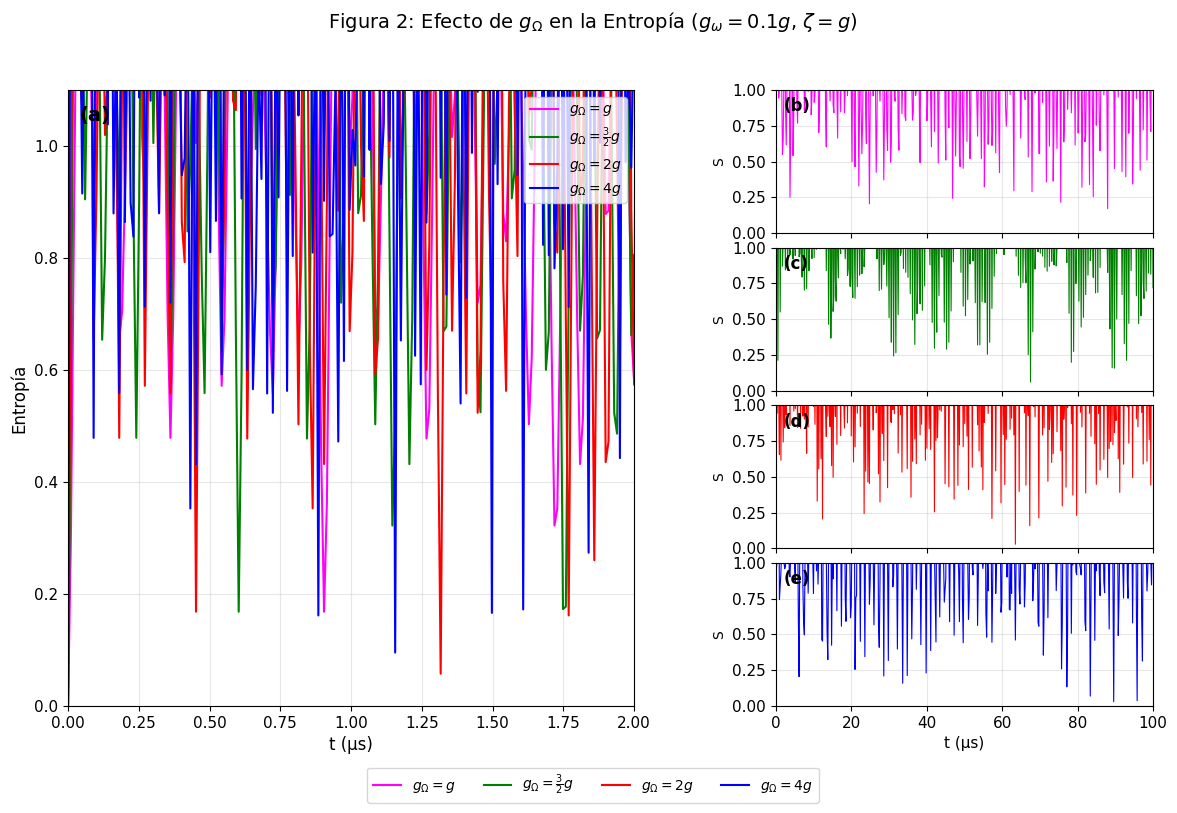


✅ Figura 2 completada


In [9]:
print("="*60)
print("FIGURA 2: Efecto de g_Ω en la entropía")
print("="*60)

# Parámetros
g_fonon = 0.1 * G_BASE
zeta = G_BASE

# Tiempo corto para panel (a)
t_corto = np.linspace(0, 2e-6, 200)
# Tiempo largo para paneles (b-e)
t_largo = np.linspace(0, 1e-4, 500)

valores_g_omega = [G_BASE, 1.5*G_BASE, 2*G_BASE, 4*G_BASE]
colores = ['magenta', 'green', 'red', 'blue']
etiquetas = [r'$g_\Omega = g$', r'$g_\Omega = \frac{3}{2}g$', r'$g_\Omega = 2g$', r'$g_\Omega = 4g$']

# Simular
resultados_corto = {}
resultados_largo = {}

for g_om, etiq in zip(valores_g_omega, etiquetas):
    print(f"Simulando {etiq}...")
    resultados_corto[etiq] = simular(g_om, g_fonon, zeta, t_corto)
    resultados_largo[etiq] = simular(g_om, g_fonon, zeta, t_largo)

# Crear figura con layout del paper
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 2, width_ratios=[1.5, 1], hspace=0.1, wspace=0.3)

# Panel (a) - tiempo corto, todas las curvas juntas
ax_a = fig.add_subplot(gs[:, 0])
for g_om, color, etiq in zip(valores_g_omega, colores, etiquetas):
    ax_a.plot(t_corto * 1e6, resultados_corto[etiq], color=color, linewidth=1.5, label=etiq)
ax_a.set_xlabel('t (μs)', fontsize=12)
ax_a.set_ylabel('Entropía', fontsize=12)
ax_a.set_xlim(0, 2)
ax_a.set_ylim(0, 1.1)
ax_a.text(0.02, 0.95, '(a)', transform=ax_a.transAxes, fontsize=14, fontweight='bold')
ax_a.legend(loc='upper right', fontsize=10)
ax_a.grid(True, alpha=0.3)

# Paneles (b-e) - tiempo largo, una curva cada uno
panel_nombres = ['(b)', '(c)', '(d)', '(e)']
for i, (etiq, color, nombre) in enumerate(zip(etiquetas, colores, panel_nombres)):
    ax = fig.add_subplot(gs[i, 1])
    ax.plot(t_largo * 1e6, resultados_largo[etiq], color=color, linewidth=0.8)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 100)
    ax.text(0.02, 0.85, nombre, transform=ax.transAxes, fontsize=12, fontweight='bold')
    if i == 3:
        ax.set_xlabel('t (μs)', fontsize=11)
    else:
        ax.set_xticklabels([])
    ax.set_ylabel('S', fontsize=10)
    ax.grid(True, alpha=0.3)

# Leyenda inferior
fig.legend(etiquetas, loc='lower center', ncol=4, fontsize=10, 
           bbox_to_anchor=(0.5, -0.02), frameon=True)

plt.suptitle(r'Figura 2: Efecto de $g_\Omega$ en la Entropía ($g_\omega = 0.1g$, $\zeta = g$)', 
             fontsize=14, y=0.98)
plt.tight_layout()
plt.savefig('figura_2.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figura 2 completada")

## 5️⃣ Figura 3 - Efecto de g_ω

**Parámetros**: g_Ω = g, ζ = g, g_ω ∈ {g/100, g/20, g/10, g/5}

FIGURA 3: Efecto de g_ω en la entropía
Simulando $g_\omega = \frac{1}{100}g$...
Simulando $g_\omega = \frac{1}{20}g$...
Simulando $g_\omega = \frac{1}{10}g$...
Simulando $g_\omega = \frac{1}{5}g$...


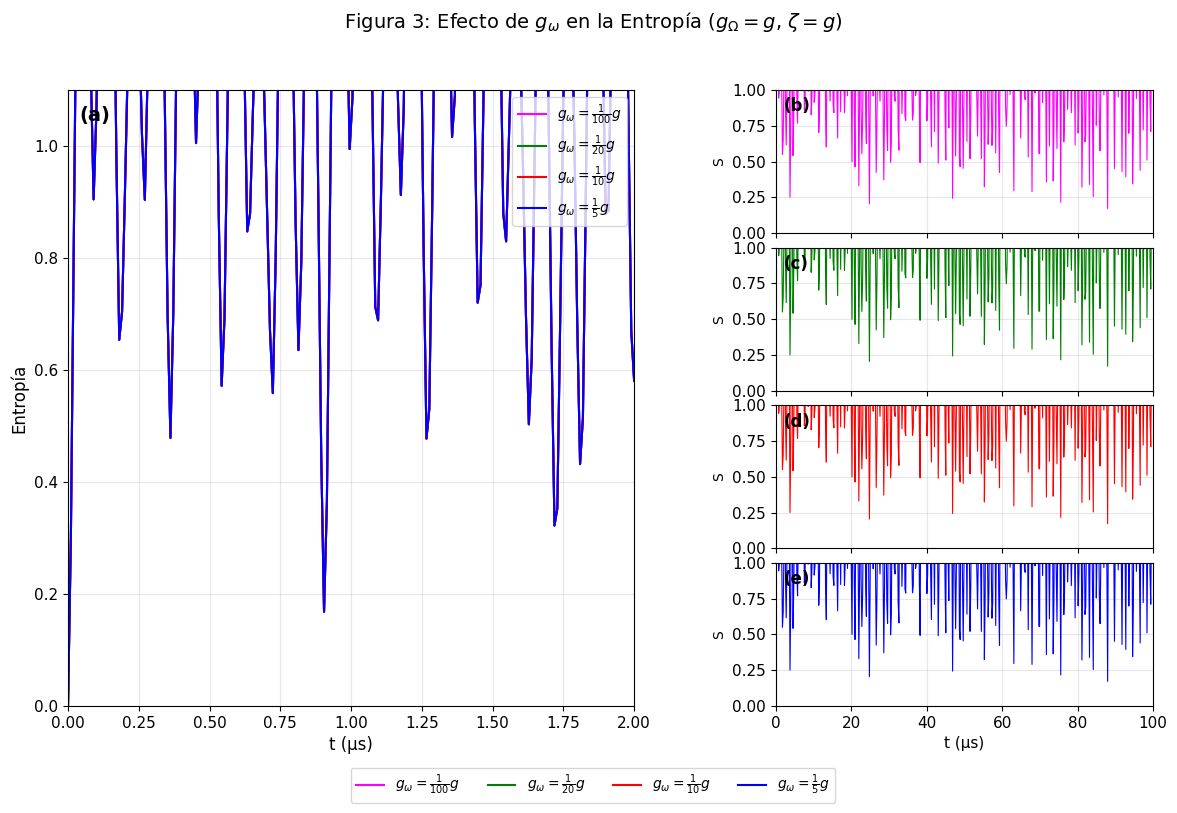


✅ Figura 3 completada


In [10]:
print("="*60)
print("FIGURA 3: Efecto de g_ω en la entropía")
print("="*60)

# Parámetros
g_omega = G_BASE
zeta = G_BASE

t_corto = np.linspace(0, 2e-6, 200)
t_largo = np.linspace(0, 1e-4, 500)

valores_g_fonon = [G_BASE/100, G_BASE/20, G_BASE/10, G_BASE/5]
colores = ['magenta', 'green', 'red', 'blue']
etiquetas = [r'$g_\omega = \frac{1}{100}g$', r'$g_\omega = \frac{1}{20}g$', 
             r'$g_\omega = \frac{1}{10}g$', r'$g_\omega = \frac{1}{5}g$']

resultados_corto = {}
resultados_largo = {}

for g_fn, etiq in zip(valores_g_fonon, etiquetas):
    print(f"Simulando {etiq}...")
    resultados_corto[etiq] = simular(g_omega, g_fn, zeta, t_corto)
    resultados_largo[etiq] = simular(g_omega, g_fn, zeta, t_largo)

# Crear figura
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 2, width_ratios=[1.5, 1], hspace=0.1, wspace=0.3)

# Panel (a)
ax_a = fig.add_subplot(gs[:, 0])
for g_fn, color, etiq in zip(valores_g_fonon, colores, etiquetas):
    ax_a.plot(t_corto * 1e6, resultados_corto[etiq], color=color, linewidth=1.5, label=etiq)
ax_a.set_xlabel('t (μs)', fontsize=12)
ax_a.set_ylabel('Entropía', fontsize=12)
ax_a.set_xlim(0, 2)
ax_a.set_ylim(0, 1.1)
ax_a.text(0.02, 0.95, '(a)', transform=ax_a.transAxes, fontsize=14, fontweight='bold')
ax_a.legend(loc='upper right', fontsize=10)
ax_a.grid(True, alpha=0.3)

# Paneles (b-e)
panel_nombres = ['(b)', '(c)', '(d)', '(e)']
for i, (etiq, color, nombre) in enumerate(zip(etiquetas, colores, panel_nombres)):
    ax = fig.add_subplot(gs[i, 1])
    ax.plot(t_largo * 1e6, resultados_largo[etiq], color=color, linewidth=0.8)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 100)
    ax.text(0.02, 0.85, nombre, transform=ax.transAxes, fontsize=12, fontweight='bold')
    if i == 3:
        ax.set_xlabel('t (μs)', fontsize=11)
    else:
        ax.set_xticklabels([])
    ax.set_ylabel('S', fontsize=10)
    ax.grid(True, alpha=0.3)

fig.legend(etiquetas, loc='lower center', ncol=4, fontsize=10, 
           bbox_to_anchor=(0.5, -0.02), frameon=True)

plt.suptitle(r'Figura 3: Efecto de $g_\omega$ en la Entropía ($g_\Omega = g$, $\zeta = g$)', 
             fontsize=14, y=0.98)
plt.tight_layout()
plt.savefig('figura_3.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figura 3 completada")

## 6️⃣ Figura 4 - Efecto de ζ (Tunelamiento)

**Parámetros**: g_Ω = g, g_ω = g/10, ζ ∈ {g/10, g/2, g, 3g/2}

FIGURA 4: Efecto del tunelamiento ζ
Simulando $\zeta = \frac{1}{10}g$...
Simulando $\zeta = \frac{1}{2}g$...
Simulando $\zeta = g$...
Simulando $\zeta = \frac{3}{2}g$...


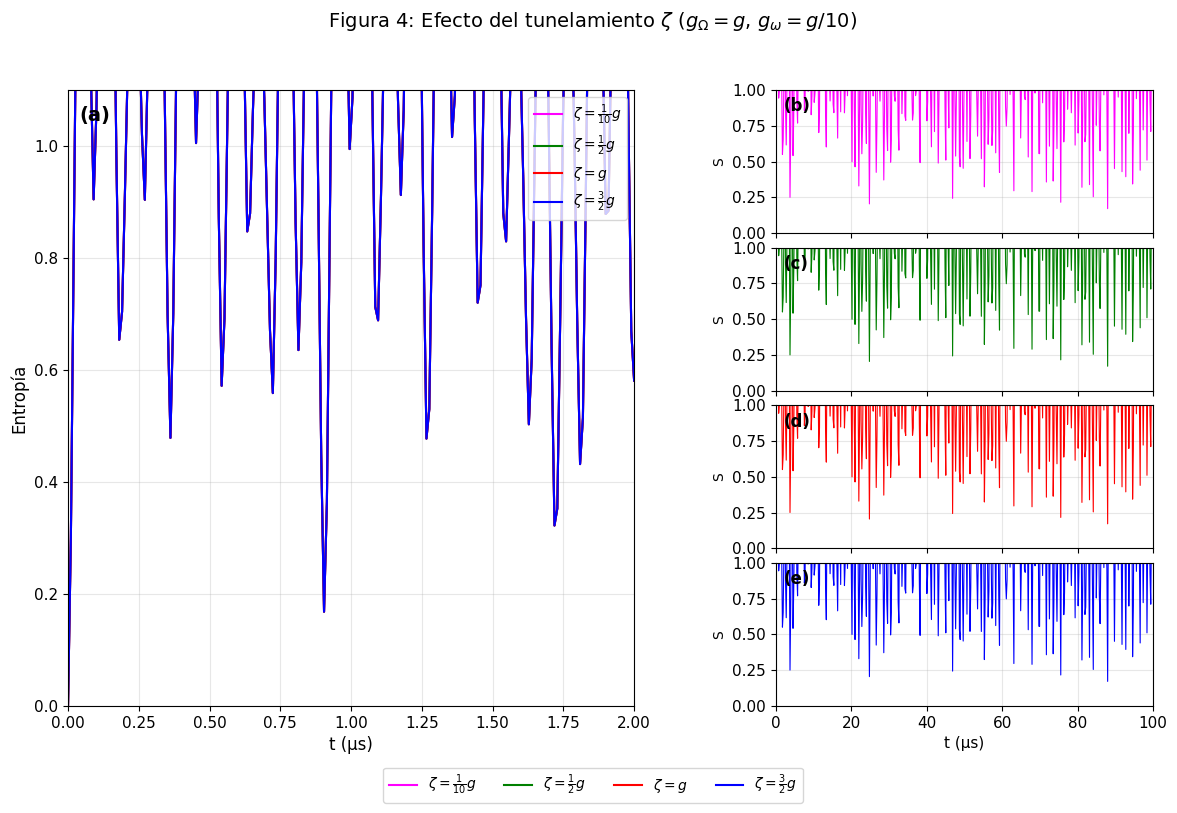


✅ Figura 4 completada


In [11]:
print("="*60)
print("FIGURA 4: Efecto del tunelamiento ζ")
print("="*60)

g_omega = G_BASE
g_fonon = G_BASE / 10

t_corto = np.linspace(0, 2e-6, 200)
t_largo = np.linspace(0, 1e-4, 500)

valores_zeta = [G_BASE/10, G_BASE/2, G_BASE, 1.5*G_BASE]
colores = ['magenta', 'green', 'red', 'blue']
etiquetas = [r'$\zeta = \frac{1}{10}g$', r'$\zeta = \frac{1}{2}g$', 
             r'$\zeta = g$', r'$\zeta = \frac{3}{2}g$']

resultados_corto = {}
resultados_largo = {}

for z, etiq in zip(valores_zeta, etiquetas):
    print(f"Simulando {etiq}...")
    resultados_corto[etiq] = simular(g_omega, g_fonon, z, t_corto)
    resultados_largo[etiq] = simular(g_omega, g_fonon, z, t_largo)

# Crear figura
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 2, width_ratios=[1.5, 1], hspace=0.1, wspace=0.3)

ax_a = fig.add_subplot(gs[:, 0])
for z, color, etiq in zip(valores_zeta, colores, etiquetas):
    ax_a.plot(t_corto * 1e6, resultados_corto[etiq], color=color, linewidth=1.5, label=etiq)
ax_a.set_xlabel('t (μs)', fontsize=12)
ax_a.set_ylabel('Entropía', fontsize=12)
ax_a.set_xlim(0, 2)
ax_a.set_ylim(0, 1.1)
ax_a.text(0.02, 0.95, '(a)', transform=ax_a.transAxes, fontsize=14, fontweight='bold')
ax_a.legend(loc='upper right', fontsize=10)
ax_a.grid(True, alpha=0.3)

panel_nombres = ['(b)', '(c)', '(d)', '(e)']
for i, (etiq, color, nombre) in enumerate(zip(etiquetas, colores, panel_nombres)):
    ax = fig.add_subplot(gs[i, 1])
    ax.plot(t_largo * 1e6, resultados_largo[etiq], color=color, linewidth=0.8)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 100)
    ax.text(0.02, 0.85, nombre, transform=ax.transAxes, fontsize=12, fontweight='bold')
    if i == 3:
        ax.set_xlabel('t (μs)', fontsize=11)
    else:
        ax.set_xticklabels([])
    ax.set_ylabel('S', fontsize=10)
    ax.grid(True, alpha=0.3)

fig.legend(etiquetas, loc='lower center', ncol=4, fontsize=10, 
           bbox_to_anchor=(0.5, -0.02), frameon=True)

plt.suptitle(r'Figura 4: Efecto del tunelamiento $\zeta$ ($g_\Omega = g$, $g_\omega = g/10$)', 
             fontsize=14, y=0.98)
plt.tight_layout()
plt.savefig('figura_4.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figura 4 completada")

## 7️⃣ Figura 5 - Heatmap de Entropía Máxima

Mapa 2D de entropía máxima vs g_Ω y ζ

FIGURA 5: Heatmap de entropía máxima
⚠️ Esto puede tomar varios minutos...
  Progreso: 20/225
  Progreso: 40/225
  Progreso: 60/225
  Progreso: 80/225
  Progreso: 100/225
  Progreso: 120/225
  Progreso: 140/225
  Progreso: 160/225
  Progreso: 180/225
  Progreso: 200/225
  Progreso: 220/225


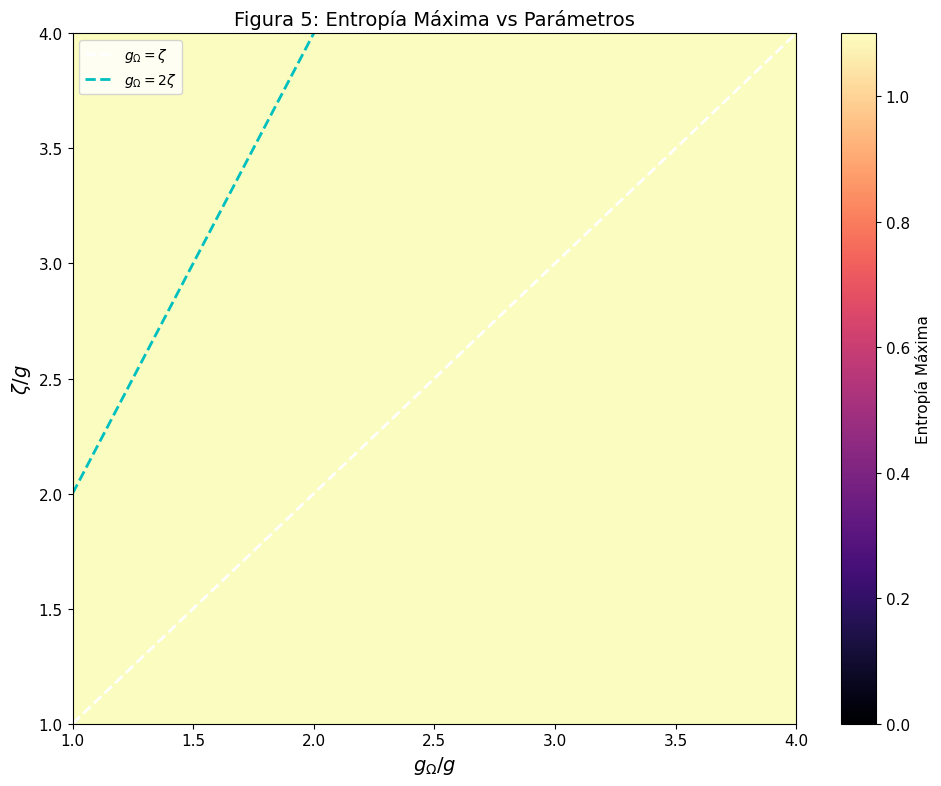


✅ Figura 5 completada


In [12]:
print("="*60)
print("FIGURA 5: Heatmap de entropía máxima")
print("⚠️ Esto puede tomar varios minutos...")
print("="*60)

g_fonon = G_BASE / 10
t_sim = np.linspace(0, 2e-6, 100)

# Rango de g_Ω y ζ
n_grid = 15  # Reducir para pruebas rápidas
g_omega_vals = np.linspace(G_BASE, 4*G_BASE, n_grid)
zeta_vals = np.linspace(G_BASE, 4*G_BASE, n_grid)

entropia_max = np.zeros((n_grid, n_grid))

total_sims = n_grid * n_grid
contador = 0

for i, g_om in enumerate(g_omega_vals):
    for j, z in enumerate(zeta_vals):
        entropias = simular(g_om, g_fonon, z, t_sim)
        entropia_max[j, i] = np.max(entropias)  # j=ζ, i=g_Ω
        contador += 1
        if contador % 20 == 0:
            print(f"  Progreso: {contador}/{total_sims}")

# Graficar
fig, ax = plt.subplots(figsize=(10, 8))

# Normalizar ejes a unidades de g
extent = [1, 4, 1, 4]  # g_Ω: 1g-4g, ζ: 1g-4g

im = ax.imshow(entropia_max, origin='lower', extent=extent, 
               aspect='auto', cmap='magma', vmin=0, vmax=1.1)

# Colorbar
cbar = plt.colorbar(im, ax=ax, label='Entropía Máxima')

# Líneas de cresta
ax.plot([1, 4], [1, 4], 'w--', linewidth=2, label=r'$g_\Omega = \zeta$')
ax.plot([1, 2], [2, 4], 'c--', linewidth=2, label=r'$g_\Omega = 2\zeta$')

ax.set_xlabel(r'$g_\Omega / g$', fontsize=14)
ax.set_ylabel(r'$\zeta / g$', fontsize=14)
ax.set_title('Figura 5: Entropía Máxima vs Parámetros', fontsize=14)
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('figura_5.png', dpi=150)
plt.show()

print("\n✅ Figura 5 completada")

## 8️⃣ Figura 6 - Casos g_Ω = ζ

Subplots apilados para g_Ω = ζ ∈ {g, 2g, 3g, 4g}

FIGURA 6: Casos g_Ω = ζ
Simulando $g_\Omega = \zeta = g$...
Simulando $g_\Omega = \zeta = 2g$...
Simulando $g_\Omega = \zeta = 3g$...
Simulando $g_\Omega = \zeta = 4g$...


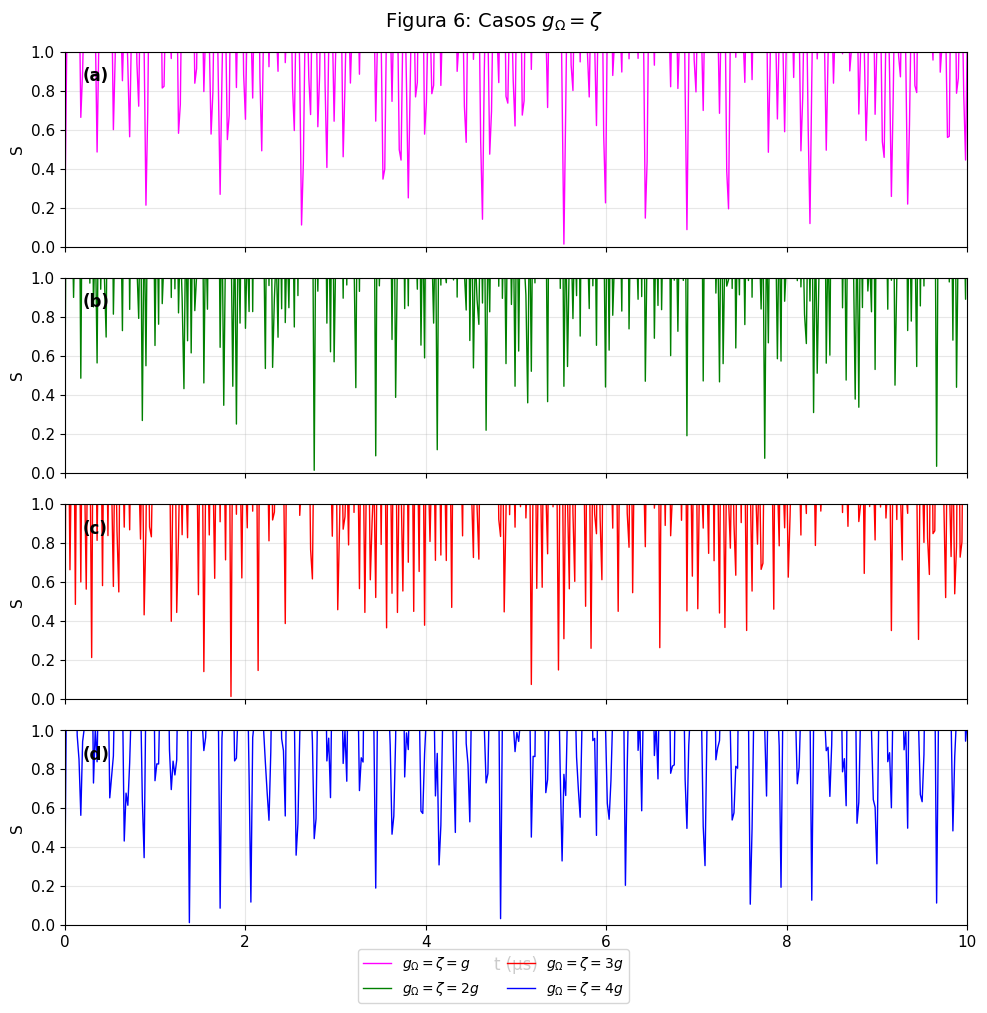


✅ Figura 6 completada


In [13]:
print("="*60)
print("FIGURA 6: Casos g_Ω = ζ")
print("="*60)

g_fonon = G_BASE / 10
tiempos = np.linspace(0, 1e-5, 500)

valores = [G_BASE, 2*G_BASE, 3*G_BASE, 4*G_BASE]
colores = ['magenta', 'green', 'red', 'blue']
etiquetas = [r'$g_\Omega = \zeta = g$', r'$g_\Omega = \zeta = 2g$',
             r'$g_\Omega = \zeta = 3g$', r'$g_\Omega = \zeta = 4g$']

fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

panel_nombres = ['(a)', '(b)', '(c)', '(d)']

for i, (val, color, etiq, nombre) in enumerate(zip(valores, colores, etiquetas, panel_nombres)):
    print(f"Simulando {etiq}...")
    entropias = simular(val, g_fonon, val, tiempos)
    
    axes[i].plot(tiempos * 1e6, entropias, color=color, linewidth=1)
    axes[i].set_ylim(0, 1)
    axes[i].set_xlim(0, 10)
    axes[i].text(0.02, 0.85, nombre, transform=axes[i].transAxes, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('S', fontsize=11)
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('t (μs)', fontsize=12)

# Leyenda inferior
fig.legend(etiquetas, loc='lower center', ncol=2, fontsize=10, 
           bbox_to_anchor=(0.5, -0.02), frameon=True)

plt.suptitle(r'Figura 6: Casos $g_\Omega = \zeta$', fontsize=14, y=0.98)
plt.tight_layout()
plt.savefig('figura_6.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figura 6 completada")

---

## 🎉 Resumen

| Figura | Descripción | Variables | 
|--------|-------------|----------|
| 2 | Efecto de g_Ω | g_Ω ∈ {g, 1.5g, 2g, 4g} |
| 3 | Efecto de g_ω | g_ω ∈ {g/100, g/20, g/10, g/5} |
| 4 | Efecto de ζ | ζ ∈ {g/10, g/2, g, 3g/2} |
| 5 | Heatmap 2D | g_Ω vs ζ |
| 6 | Casos g_Ω = ζ | g, 2g, 3g, 4g |

### Notas:
- Aumentar `DIM_PHOTON` y `DIM_PHONON` para mayor precisión
- Los resultados dependen del truncamiento del espacio de Fock